<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>XGBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('/datasets/taxi.csv')
display(data.head())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [27]:
print(data.duplicated().sum())

0


Дубликатов нет. Переведем формат столбца 'datetime' во временной

In [15]:
data['datetime'] = pd.to_datetime(data['datetime'], format = '%Y%m%d %H:%M:%S')

Сделаем столбец 'datetime' индексами нашей таблицы

In [16]:
data = data.set_index('datetime')

In [17]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [20]:
a = data['2018-03-01 00:00:00':'2018-03-01 00:00:00'].drop(['num_orders'], axis=1)

In [30]:
data = data.sort_index()

In [31]:
data.index.is_monotonic

True

Даты расположены в хронологическом порядке. Сделаем ресемплирование по 1 часу, ведь нас интересует информация по часам

In [32]:
data = data.resample('1H').sum()

## Анализ

<AxesSubplot:xlabel='datetime'>

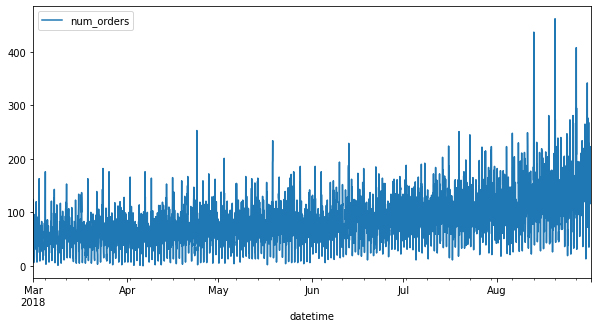

In [33]:
data.plot(figsize=(10,5))

In [34]:
data['rolling_mean'] = data.rolling(10).mean()

<AxesSubplot:xlabel='datetime'>

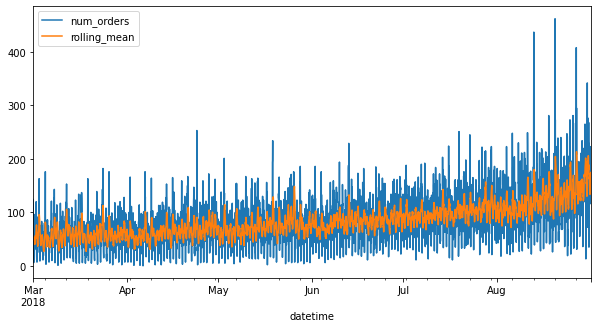

In [35]:
data.plot(figsize=(10,5))

In [36]:
data = data.drop('rolling_mean', axis=1)

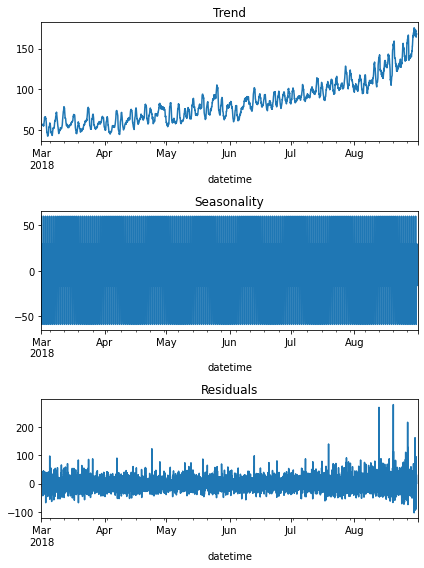

In [37]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

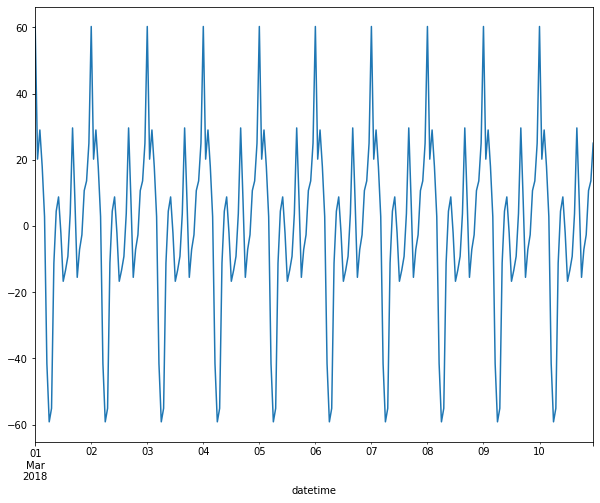

In [38]:
decomposed.seasonal['2018-03-01':'2018-03-10'].plot(figsize=(10, 8))

Даны данные с марта по август 2018 года. Наблюдается тренд на увеличение заказов такси в более теплое время года. В августе самое большое количество заказов. Видимо, люди летают в отпуск в "бархатный" cезон. Для сезонности у нас мало данных, но можно сказать, что рост количества заказов такси происходит в период с 20:00 до 2:00

## Обучение

Добавим признки в наши данные. Добавим информацию о месяце, числе месяца и дне недели. А так же отстающие значения

In [40]:
def make_features(data, max_lag):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['is_weekend'] = data.dayofweek.isin([5,6])*1
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

In [41]:
make_features(data, 7)

In [42]:
data['rolling_mean'] = data['num_orders'].rolling(24).mean()

In [43]:
data

,num_orders,month,day,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,0,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,0,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,0,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,0,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,0,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.541667
2018-08-31 20:00:00,154,8,31,4,0,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,168.041667
2018-08-31 21:00:00,159,8,31,4,0,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.416667


Удалим строки с пропущенными значениями

In [45]:
data = data.dropna()

Проверим

In [46]:
data

,num_orders,month,day,dayofweek,is_weekend,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-01 23:00:00,58,3,1,3,0,23,113.0,66.0,61.0,45.0,73.0,44.0,43.0,56.833333
2018-03-02 00:00:00,90,3,2,4,0,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,55.416667
2018-03-02 01:00:00,120,3,2,4,0,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,56.875000
2018-03-02 02:00:00,75,3,2,4,0,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,57.041667
2018-03-02 03:00:00,64,3,2,4,0,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,56.958333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,0,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.541667
2018-08-31 20:00:00,154,8,31,4,0,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,168.041667
2018-08-31 21:00:00,159,8,31,4,0,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.416667


Разделим данные на тренировочную и тестовую выборки 

In [47]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders'] 

cat_features = ['month', 'day', 'dayofweek', 'is_weekend']
for c in cat_features:
    features[c] = features[c].astype('category')
    

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False)

In [48]:
features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4393 entries, 2018-03-01 23:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   month         4393 non-null   category
 1   day           4393 non-null   category
 2   dayofweek     4393 non-null   category
 3   is_weekend    4393 non-null   category
 4   hour          4393 non-null   int64   
 5   lag_1         4393 non-null   float64 
 6   lag_2         4393 non-null   float64 
 7   lag_3         4393 non-null   float64 
 8   lag_4         4393 non-null   float64 
 9   lag_5         4393 non-null   float64 
 10  lag_6         4393 non-null   float64 
 11  lag_7         4393 non-null   float64 
 12  rolling_mean  4393 non-null   float64 
dtypes: category(4), float64(8), int64(1)
memory usage: 362.3 KB


In [49]:
features_train.shape

(3953, 13)

In [50]:
features_test.shape

(440, 13)

Данные готовы к дальнейшей работе

### Линейная регрессия

In [51]:
model_LR = LinearRegression()
scores_LR = cross_val_score(model_LR, features_train, target_train, scoring='neg_mean_squared_error', 
                                          cv=TimeSeriesSplit(n_splits=5))
print(scores_LR)
print((scores_LR.mean()*(-1))**0.5)

[ -741.1670136   -827.29736326  -892.50132804  -991.18490296
 -1498.71209593]
31.467007178300744


### Дерево решений

In [52]:
%%time
grid = { 
    'max_features': ['sqrt', 'log2'],
    'max_depth' : range(1,11), 
    'random_state' : [148],}
model_DT = DecisionTreeRegressor()
gsc = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=grid, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5))
gsc.fit(features_train, target_train)
gsc.best_params_

CPU times: user 847 ms, sys: 23.9 ms, total: 871 ms
Wall time: 882 ms


{'max_depth': 7, 'max_features': 'sqrt', 'random_state': 148}

In [53]:
print('RMSE:', (gsc.best_score_ *(-1))**0.5)
gsc.best_estimator_

RMSE: 32.064381379121684


DecisionTreeRegressor(max_depth=7, max_features='sqrt', random_state=148)

### Случайный лес


In [54]:
%%time
grid = { 
    'n_estimators': range(1,50, 10),
    'max_features': ['sqrt', 'log2'],
    'max_depth' : range(1,11),
    'random_state' : [148]}
model_RF = RandomForestRegressor()
gsc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=5))
gsc.fit(features_train, target_train)
gsc.best_params_

CPU times: user 25.7 s, sys: 85 ms, total: 25.8 s
Wall time: 25.8 s


{'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 41,
 'random_state': 148}

In [55]:
print('RMSE:', (gsc.best_score_ *(-1))**0.5)
gsc.best_estimator_

RMSE: 26.6223457793723


RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=41,
                      random_state=148)

### CatBoost

In [56]:
cat_features = ['month', 'day', 'dayofweek', 'is_weekend']

In [57]:
grid = { 
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'depth': range(4,11),
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'n_estimators': range(1,50, 10)
}


In [58]:
%%time
gsc = GridSearchCV(estimator=CatBoostRegressor(verbose=False), param_grid=grid, 
                   cv= TimeSeriesSplit(n_splits=5), scoring='neg_mean_squared_error')
gsc.fit(features_train, target_train, cat_features=cat_features)
gsc.best_params_

CPU times: user 10min 11s, sys: 45.7 s, total: 10min 56s
Wall time: 23min 25s


{'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'n_estimators': 41}

In [59]:
print(gsc.best_score_)
print('RMSE:', (gsc.best_score_ *(-1))**0.5)
gsc.best_estimator_

-723.5983091007914
RMSE: 26.89978269616302


### LightGBM

In [60]:
grid = { 
    'max_depth': range(3,8,2),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'n_estimators': range(1,50, 10),
    'boosting_type': ['gbdt', 'dart', 'goss']
} 


In [64]:
model = CatBoostRegressor(verbose=False, learning_rate=0.1, depth=8, n_estimators=41, random_state=148, l2_leaf_reg=1)
model.fit(features_train, target_train, cat_features=cat_features)
prediction = model.predict(features_test)
mean_squared_error(target_test, prediction)**0.5

47.670042227714916

In [61]:
%%time
gsc = GridSearchCV(estimator=LGBMRegressor(), param_grid=grid, cv= TimeSeriesSplit(n_splits=5), 
                     scoring='neg_mean_squared_error')
gsc.fit(features_train, target_train)
gsc.best_params_

CPU times: user 6min 21s, sys: 3.03 s, total: 6min 24s
Wall time: 6min 28s


{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 41}

In [62]:
print(gsc.best_score_)
print('RMSE:', (gsc.best_score_ *(-1))**0.5)
gsc.best_estimator_

-630.6529775593772
RMSE: 25.11280505159424


LGBMRegressor(max_depth=7, n_estimators=41)

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = pd.DataFrame(scaler.fit_transform(features_train), columns=features_train.columns)
features_test_scaled = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

In [63]:
model = LGBMRegressor(boosting_type='gbdt', learning_rate= 0.1, max_depth= 7, n_estimators=41)
model.fit(features_train_scaled, target_train)
prediction = model.predict(features_test)
mean_squared_error(target_test, prediction)**0.5

45.70964090003668

In [106]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders'] 
    
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, shuffle=False)

### XGBoost


In [107]:
grid = { 
    'max_depth': range(3,8,2),
    'n_estimators': range(1,50, 10),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0]
} 

In [108]:
%%time
from xgboost import XGBRegressor
gsc = GridSearchCV(estimator=XGBRegressor(), param_grid=grid, cv= TimeSeriesSplit(n_splits=5), 
                     scoring='neg_mean_squared_error')
gsc.fit(features_train, target_train)
gsc.best_params_

CPU times: user 1min 53s, sys: 850 ms, total: 1min 54s
Wall time: 1min 55s


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 41}

In [109]:
print(gsc.best_score_)
print('RMSE:', (gsc.best_score_ *(-1))**0.5)
gsc.best_estimator_

-658.0652774224661
RMSE: 25.65278303464297


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=41, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Лучший показатель на валидационной выборке у нас получсился при использовании линейной регресии. Градиентные бустинги показали примерно одинаковый результат. Проверим на тестовой выборке

## Тестирование

In [112]:
model = LGBMRegressor(boosting_type='gbdt', learning_rate= 0.1, max_depth= 7, n_estimators=41)
model.fit(features_train, target_train)
prediction = model.predict(features_test)
mean_squared_error(target_test, prediction)**0.5

42.785465999221096

In [113]:
a1=target_test.reset_index(drop=True)

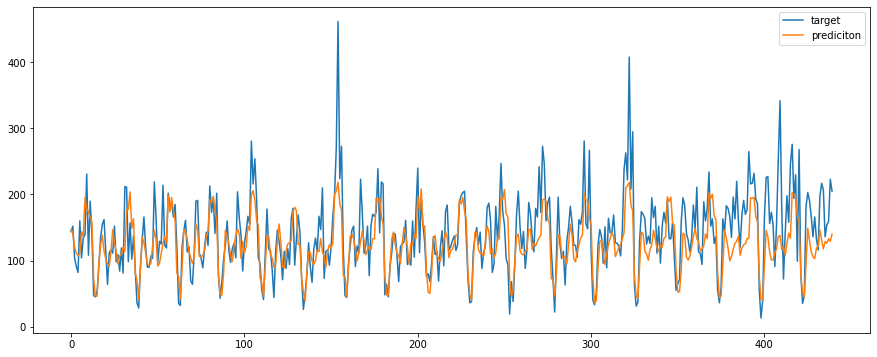

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(a1, label='target')
ax.plot(pd.DataFrame(prediction), label='prediciton')
plt.legend()
plt.show()

График с предсказнием LightGBM. Лучшая модель получилась у LightGBM. Ошибка на тестовой выборке получилась ~ 42.78. По условию задачи, RMSE не должна быть больше 48